In [129]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [52]:
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [53]:
context_len = 3
X, Y = [], []

for w in words:
    context = [0] * context_len

    for l in w + '.':
        ix = stoi[l]
        X.append(context)
        Y.append(ix)
        # print(''.join([itos[i] for i in context]), "->", itos[ix])
        context = context[1:] + [ix]

X, Y = torch.tensor(X), torch.tensor(Y)
print(X.size(), Y.size())

torch.Size([228146, 3]) torch.Size([228146])


In [54]:
C = torch.randn(27, 2)
emb = C[X] # each element of X(corresponding to each letter in the context) is given the appropriate 2-D weight
emb.size()

torch.Size([228146, 3, 2])

In [55]:
emb_c = emb.view(Y.size(0), -1)
emb_c.size()

torch.Size([228146, 6])

In [56]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [57]:
h = torch.tanh(emb_c @ W1 + b1)
h.size()

torch.Size([228146, 100])

In [58]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
W2.size()

torch.Size([100, 27])

In [59]:
logits = h @ W2 + b2
counts = logits.exp()
probs = counts/counts.sum(1, keepdim=True)
probs.size()

torch.Size([228146, 27])

In [60]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [61]:
import torch.nn.functional as F

loss = -probs[torch.arange(Y.shape[0]), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(17.9444)

In [131]:
# Consolidation
C = torch.randn(27, 2)
W1 = torch.randn(6, 100)
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [132]:
num_iter = 100
steps = []
losses = []

for i in range(num_iter):
    parameters  = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
        loss.backward(retain_graph=True)
    
    # update
    #lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    steps.append(i)
    losses.append(loss)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

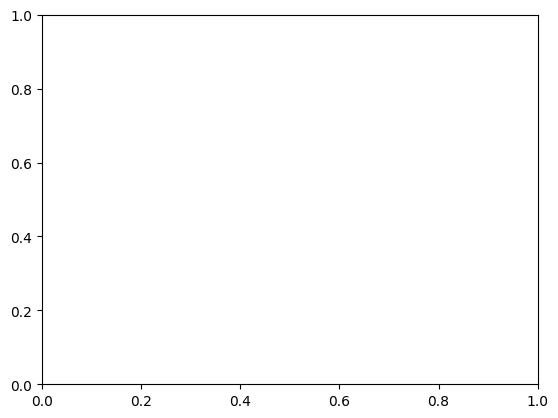

In [133]:
plt.plot(steps, losses)